In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import math
import pickle
import io
import os
import glob
import time

camera = pickle.load(open("camera_matrix.pkl", "rb"))
mtx = camera['mtx']
dist = camera['dist']
camera_img_size = camera['imagesize']

In [4]:
def undistort(img, mtx, dist, camera_img_size):
    img_size1 = (img.shape[1], img.shape[0])
    assert (img_size1 == camera_img_size), 'image size is not compatible'
    undist = cv.undistort(img, mtx, dist, None, mtx)
    return undist

In [213]:
img = mpimg.imread('calibration4.jpg')
img_size1 = (img.shape[1], img.shape[0])

undist = undistort(img, mtx, dist, img_size1)

'''
#Visualize the distorted and undistorted images
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Captured Image', fontsize = 30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize = 30)
plt.tight_layout()
'''

"\n#Visualize the distorted and undistorted images\nplt.figure()\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))\nax1.imshow(img)\nax1.set_title('Captured Image', fontsize = 30)\nax2.imshow(undist)\nax2.set_title('Undistorted Image', fontsize = 30)\nplt.tight_layout()\n"

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def sobel_filter(img, orient='x', thresh=(0,255)):
    start_time = time.time()
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1))
    
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    print(time.time() - start_time)
    
    return binary_output

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv.bitwise_and(img, mask)
    return masked_image

#used below
def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)

#thick red lines 
def draw_lines(img, lines, color=[255, 255, 255], thickness=6):
    """workflow:
    1) examine each individual line returned by hough & determine if it's in left or right lane by its slope
    because we are working "upside down" with the array, the left lane will have a negative slope and right positive
    2) track extrema
    3) compute averages
    4) solve for b intercept 
    5) use extrema to solve for points
    6) smooth frames and cache
    """
    global cache
    global first_frame
    y_global_min = img.shape[0] #min will be the "highest" y value, or point down the road away from car
    y_max = img.shape[0]
    l_slope, r_slope = [],[]
    l_lane,r_lane = [],[]
    det_slope = 0.4
    α =0.2 
    #i got this alpha value off of the forums for the weighting between frames.
    #i understand what it does, but i dont understand where it comes from
    #much like some of the parameters in the hough function
    
    for line in lines:
        #1
        for x1,y1,x2,y2 in line:
            slope = get_slope(x1,y1,x2,y2)
            if slope > det_slope:
                r_slope.append(slope)
                r_lane.append(line)
            elif slope < -det_slope:
                l_slope.append(slope)
                l_lane.append(line)
        #2
        y_global_min = min(y1,y2,y_global_min)
    
    # to prevent errors in challenge video from dividing by zero
    if((len(l_lane) == 0) or (len(r_lane) == 0)):
        print ('no lane detected')
        return 1
        
    #3
    l_slope_mean = np.mean(l_slope,axis =0)
    r_slope_mean = np.mean(r_slope,axis =0)
    l_mean = np.mean(np.array(l_lane),axis=0)
    r_mean = np.mean(np.array(r_lane),axis=0)
    
    if ((r_slope_mean == 0) or (l_slope_mean == 0 )):
        print('dividing by zero')
        return 1
    
   
    
    #4, y=mx+b -> b = y -mx
    l_b = l_mean[0][1] - (l_slope_mean * l_mean[0][0])
    r_b = r_mean[0][1] - (r_slope_mean * r_mean[0][0])
    
    #5, using y-extrema (#2), b intercept (#4), and slope (#3) solve for x using y=mx+b
    # x = (y-b)/m
    # these 4 points are our two lines that we will pass to the draw function
    l_x1 = int((y_global_min - l_b)/l_slope_mean) 
    l_x2 = int((y_max - l_b)/l_slope_mean)   
    r_x1 = int((y_global_min - r_b)/r_slope_mean)
    r_x2 = int((y_max - r_b)/r_slope_mean)
    
    #6
    if l_x1 > r_x1:
        l_x1 = int((l_x1+r_x1)/2)
        r_x1 = l_x1
        l_y1 = int((l_slope_mean * l_x1 ) + l_b)
        r_y1 = int((r_slope_mean * r_x1 ) + r_b)
        l_y2 = int((l_slope_mean * l_x2 ) + l_b)
        r_y2 = int((r_slope_mean * r_x2 ) + r_b)
    else:
        l_y1 = y_global_min
        l_y2 = y_max
        r_y1 = y_global_min
        r_y2 = y_max
      
    current_frame = np.array([l_x1,l_y1,l_x2,l_y2,r_x1,r_y1,r_x2,r_y2],dtype ="float32")
    
    if first_frame == 1:
        next_frame = current_frame        
        first_frame = 0        
    else :
        prev_frame = cache
        next_frame = (1-α)*prev_frame+α*current_frame
             
    cv.line(img, (int(next_frame[0]), int(next_frame[1])), (int(next_frame[2]),int(next_frame[3])), color, thickness)
    cv.line(img, (int(next_frame[4]), int(next_frame[5])), (int(next_frame[6]),int(next_frame[7])), color, thickness)
    
    cache = next_frame
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img,lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv.addWeighted(initial_img, α, img, β, λ)

In [4]:
def process_image(image):

    global first_frame

    gray_image = grayscale(image)
    img_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    #hsv = [hue, saturation, value]
    #more accurate range for yellow since it is not strictly black, white, r, g, or b

    lower_yellow = np.array([20, 100, 100], dtype = "uint8")
    upper_yellow = np.array([30, 255, 255], dtype="uint8")

    mask_yellow = cv.inRange(img_hsv, lower_yellow, upper_yellow)
    mask_white = cv.inRange(gray_image, 200, 255)
    mask_yw = cv.bitwise_or(mask_white, mask_yellow)
    mask_yw_image = cv.bitwise_and(gray_image, mask_yw)

    kernel_size = 5
    gauss_gray = gaussian_blur(mask_yw_image,kernel_size)

    #same as quiz values
    low_threshold = 50
    high_threshold = 150
    canny_edges = sobel_filter(image, thresh=(20,110))

    imshape = image.shape
    lower_left = [imshape[1]/9,imshape[0]]
    lower_right = [imshape[1]-imshape[1]/9,imshape[0]]
    top_left = [imshape[1]/2-imshape[1]/8,imshape[0]/2+imshape[0]/10]
    top_right = [imshape[1]/2+imshape[1]/8,imshape[0]/2+imshape[0]/10]
    vertices = [np.array([lower_left,top_left,top_right,lower_right],dtype=np.int32)]
    roi_image = region_of_interest(canny_edges, vertices)


    return roi_image

0.019984722137451172
0.020943880081176758


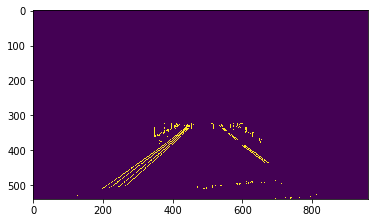

In [5]:
# set color map to gray, default is RGB
first_frame = 1
image12 = mpimg.imread('test0.jpg')
result0 = process_image(image12)
plt.imshow(process_image(image12))

In [6]:
cap = cv.VideoCapture('project_video.mp4')

while(True):
    ret, frame = cap.read()
    start_time = time.time()
    lane_frame = process_image(frame)
    print(time.time()-start_time)
    cv.imshow('frame', lane_frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

0.037901878356933594
0.0528569221496582
0.03191351890563965
0.04886913299560547
0.03192257881164551
0.0468745231628418
0.030916452407836914
0.046874046325683594
0.03490567207336426
0.05485177040100098
0.031914710998535156
0.04587864875793457
0.0329132080078125
0.05186319351196289
0.03789949417114258
0.05684781074523926
0.03390860557556152
0.056847333908081055
0.03590536117553711
0.05285835266113281
0.03390908241271973
0.05286049842834473
0.039893388748168945
0.0608367919921875
0.030918359756469727
0.04886913299560547
0.03291511535644531
0.049866437911987305
0.03291177749633789
0.05086326599121094
0.034906864166259766
0.05086255073547363
0.03191423416137695
0.046874046325683594
0.03291583061218262
0.048870086669921875
0.030916452407836914
0.047870635986328125
0.0329129695892334
0.04787278175354004
0.03091740608215332
0.04787135124206543
0.04089021682739258
0.06183600425720215
0.03091907501220703
0.04986882209777832
0.029921531677246094
0.04687619209289551
0.03690171241760254
0.053856372

0.022938966751098633


<Figure size 432x288 with 0 Axes>

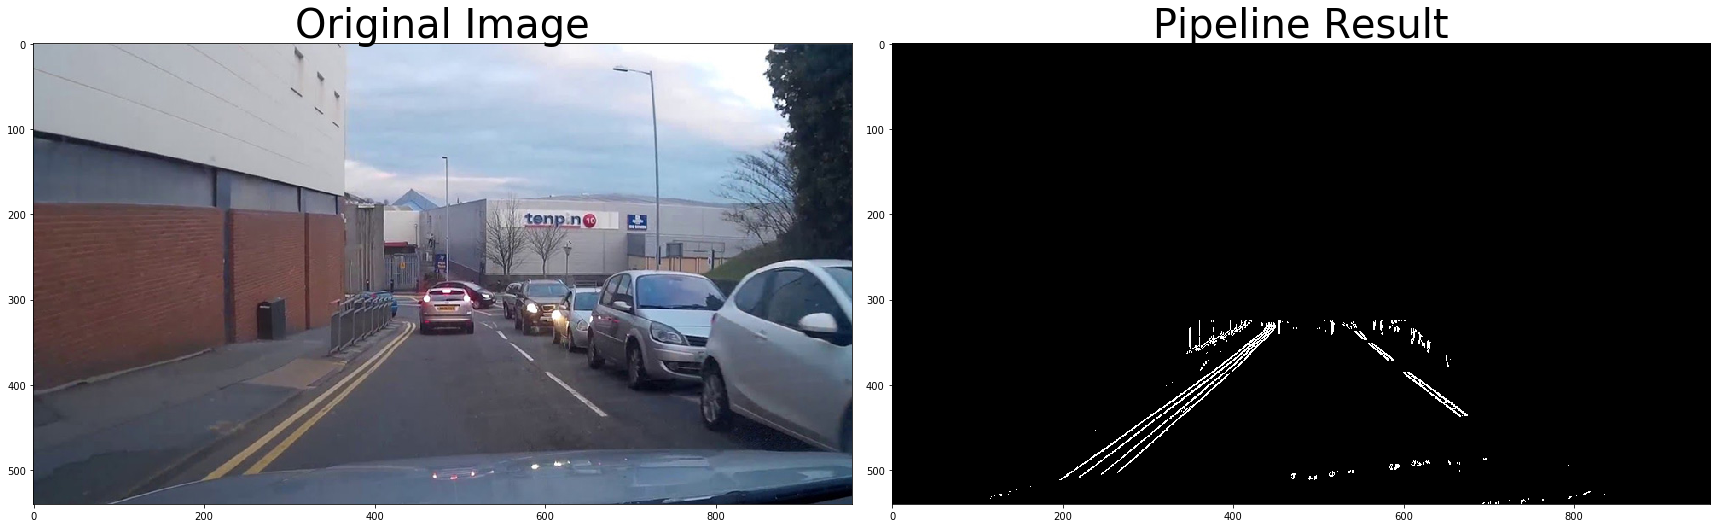

In [7]:
result = process_image(image12)

# Plot the result
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image12)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()

In [8]:
def warp_image(img):
    
    image_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]

    #the "order" of points in the polygon you are defining does not matter
    #but they need to match the corresponding points in destination_points!
    source_points = np.float32([
    [0.117 * x, y],
    [(0.5 * x) - (x*0.078), (2/3)*y],
    [(0.5 * x) + (x*0.078), (2/3)*y],
    [x - (0.117 * x), y]
    ])

#     #chicago footage
#     source_points = np.float32([
#                 [300, 720],
#                 [500, 600],
#                 [700, 600],
#                 [850, 720]
#                 ])
    
#     destination_points = np.float32([
#                 [200, 720],
#                 [200, 200],
#                 [1000, 200],
#                 [1000, 720]
#                 ])
    
    destination_points = np.float32([
    [0.25 * x, y],
    [0.25 * x, 0],
    [x - (0.25 * x), 0],
    [x - (0.25 * x), y]
    ])
    
    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points)
    inverse_perspective_transform = cv.getPerspectiveTransform( destination_points, source_points)
    
    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)
    
    #print(source_points)
    #print(destination_points)
    
    return warped_img, inverse_perspective_transform

<Figure size 432x288 with 0 Axes>

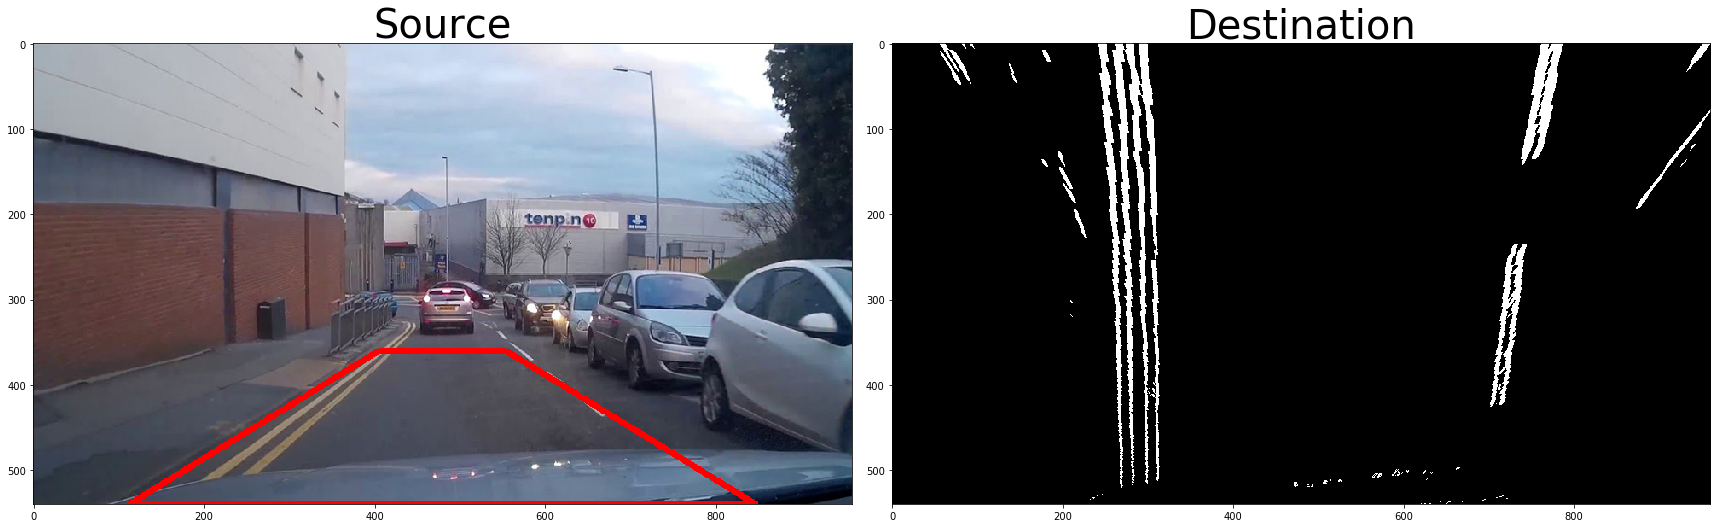

In [9]:
birdseye_result, inverse_perspective_transform = warp_image(result0)

# Plot the result
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()


image_size = (image12.shape[1], image12.shape[0])
x = image12.shape[1]
y = image12.shape[0]
source_points = np.int32([
                    [0.117 * x, y],
                    [(0.5 * x) - (x*0.078), (2/3)*y],
                    [(0.5 * x) + (x*0.078), (2/3)*y],
                    [x - (0.117 * x), y]
                    ])

draw_poly = cv.polylines(image12,[source_points],True,(255,0,0), 5)

ax1.imshow(draw_poly)
ax1.set_title('Source', fontsize=40)
ax2.imshow(birdseye_result, cmap='gray')
ax2.set_title('Destination', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.tight_layout()

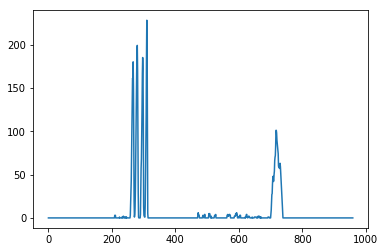

In [10]:
#look at only lower half of image
histogram = np.sum(birdseye_result[int(birdseye_result.shape[0]/2):,:], axis=0)
plt.figure()
plt.plot(histogram)

In [11]:
def track_lanes_initialize(binary_warped):
    
    global window_search
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # we need max for each half of the histogram. the example above shows how
    # things could be complicated if didn't split the image in half 
    # before taking the top 2 maxes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    # this will throw an error in the height if it doesn't evenly divide the img height
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

In [12]:
left_fit,right_fit = track_lanes_initialize(birdseye_result)

In [13]:
def track_lanes_update(binary_warped, left_fit,right_fit):

    global window_search
    global frame_count
    
    # repeat window search to maintain stability
    if frame_count % 10 == 0:
        window_search=True
   
        
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    return left_fit,right_fit,leftx,lefty,rightx,righty

In [14]:
global frame_count
frame_count=0
left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye_result, left_fit,right_fit)

In [15]:
# A function to get quadratic polynomial output
def get_val(y,poly_coeff):
    return poly_coeff[0]*y**2+poly_coeff[1]*y+poly_coeff[2]

In [16]:
def lane_fill_poly(binary_warped,undist,left_fit,right_fit):
    
    # Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast x and y for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane 
    cv.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp using inverse perspective transform
    newwarp = cv.warpPerspective(color_warp, inverse_perspective_transform, (binary_warped.shape[1], binary_warped.shape[0])) 
    # overlay
    #newwarp = cv.cvtColor(newwarp, cv.COLOR_BGR2RGB)
    result = cv.addWeighted(undist, 1, newwarp, 0.3, 0)
        
    return result

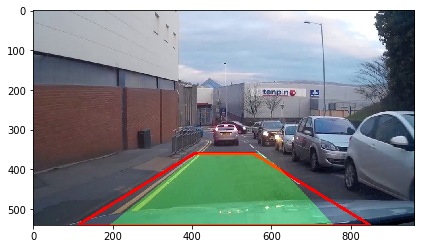

In [17]:
colored_lane = lane_fill_poly(birdseye_result, image12, left_fit, right_fit)
plt.figure()
plt.imshow(colored_lane);
plt.tight_layout()

In [18]:
def measure_curve(binary_warped,left_fit,right_fit):
        
    # generate y values 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # measure radius at the maximum y value, or bottom of the image
    # this is closest to the car 
    y_eval = np.max(ploty)
    
    # coversion rates for pixels to metric
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    # x positions lanes
    leftx = get_val(ploty,left_fit)
    rightx = get_val(ploty,right_fit)

    # fit polynomials in metric 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # calculate radii in metric from radius of curvature formula
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # averaged radius of curvature of left and right in real world space
    # should represent approximately the center of the road
    curve_rad = round((left_curverad + right_curverad)/2)
    
    return curve_rad

In [19]:
measure_curve(birdseye_result,left_fit, right_fit)

7457.0

In [20]:
def vehicle_offset(img,left_fit,right_fit):
    
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    xm_per_pix = 3.7/700 
    image_center = img.shape[1]/2
    
    ## find where lines hit the bottom of the image, closest to the car
    left_low = get_val(img.shape[0],left_fit)
    right_low = get_val(img.shape[0],right_fit)
    
    # pixel coordinate for center of lane
    lane_center = (left_low+right_low)/2.0
    
    ## vehicle offset
    distance = image_center - lane_center
    
    ## convert to metric
    return (round(distance*xm_per_pix,5))

In [21]:
offset = vehicle_offset(colored_lane, left_fit, right_fit)
print(offset)

0.02032


In [22]:
def img_pipeline(undist):
    
    global window_search
    global left_fit_prev
    global right_fit_prev
    global frame_count
    global curve_radius
    global offset
        
    # load camera matrix and distortion matrix
    camera = pickle.load(open( "camera_matrix.pkl", "rb" ))
    mtx = camera['mtx']
    dist = camera['dist']
    camera_img_size = camera['imagesize']
    
    #correct lens distortion
    #undist = undistort(img,mtx,dist,camera_img_size)
    # get binary image

    binary_img = process_image(undist)

    #perspective transform
    birdseye, inverse_perspective_transform = warp_image(binary_img)
    
    if window_search:
        #window_search = False
        #window search
        left_fit,right_fit = track_lanes_initialize(birdseye)
        #store values
        left_fit_prev = left_fit
        right_fit_prev = right_fit
        
    else:
        #load values
        left_fit = left_fit_prev
        right_fit = right_fit_prev
        #search in margin of polynomials
        left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye, left_fit,right_fit)
    
    #save values
    left_fit_prev = left_fit
    right_fit_prev = right_fit
    

    #draw polygon
    processed_frame = lane_fill_poly(birdseye, undist, left_fit, right_fit)
 
    #update ~twice per second
    if frame_count==0 or frame_count%7==0:
        #measure radii
        curve_radius = measure_curve(birdseye,left_fit,right_fit)
        #measure offset
        offset = vehicle_offset(undist, left_fit, right_fit)  
        
    #printing information to frame
    font = cv.FONT_HERSHEY_TRIPLEX
    processed_frame = cv.putText(processed_frame, 'Radius: '+str(curve_radius)+' m', (30, 40), font, 1, (0,255,0), 2)
    processed_frame = cv.putText(processed_frame, 'Car Position: '+str(offset)+' m', (30, 80), font, 1, (0,255,0), 2)
   
    frame_count += 1
    return processed_frame

In [39]:
lane_image = img_pipeline(image12)
mpimg.imsave('lane_1',lane_image)

In [23]:
cap = cv.VideoCapture('project_video.mp4')

while(True):
    ret, frame = cap.read()
    lane_frame = img_pipeline(frame)
    cv.imshow('frame', lane_frame)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

0.03191637992858887
0.03689932823181152
0.0339207649230957
0.030955076217651367
0.03191494941711426
0.035907745361328125
0.03790020942687988
0.03191542625427246
0.036902427673339844
0.03590273857116699
0.0408937931060791
0.030918359756469727
0.033945560455322266
0.03291153907775879
0.033908843994140625
0.029918670654296875
0.04391908645629883
0.03294849395751953
0.03989839553833008
0.030954599380493164
0.031916141510009766
0.03191351890563965
0.03191518783569336
0.03294849395751953
0.030953645706176758
0.032947540283203125
0.03191351890563965
0.034905195236206055
0.042885541915893555
0.034905195236206055
0.03091907501220703
0.034943342208862305
0.03192019462585449
0.034906864166259766
0.029920339584350586
0.03191375732421875
0.030917644500732422
0.032912492752075195
0.03494453430175781
0.03490900993347168
0.03390765190124512
0.035904645919799805
0.03387951850891113
0.03690195083618164
0.03889656066894531
0.030916452407836914
0.03092169761657715
0.03091573715209961
0.03295159339904785
0